In [1]:
!pip install foolbox

     |████████████████████████████████| 1.6MB 2.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 460kB 18.8MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
  Created wheel for foolbox: filename=foolbox-3.0.0-cp36-none-any.whl size=1654121 sha256=66b42eb186d7f98648b7d375b52f62bbf858d27ad877d64ce4f0489c262f2c4c
  Stored in directory: /root/.cache/pip/wheels/90/0f/10/8e0ad204b31ae13d9a2f7d5dec988b8adcd5fd7a9870680866
Successfully built foolbox
ERROR: chainer 6.5.0 has requirement typing-extensions<=3.6.6, but you'll have typing-extensions 3.7.4.2 which is incompatible.
  Found existing installation: typing-extensions 3.6.6
    Uninstalling typing-extensions-3.6.6:
      Successfully uninstalled typing-extensions-3.6.6


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
# import foolbox
import os

import torchvision.models as models
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
import foolbox.attacks as fa
import foolbox.distances as fd


In [3]:
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")


CUDA Available:  True


In [4]:
from google.colab import drive
drive.mount('/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
path =  '/gdrive/My Drive/Tmp/'

In [ ]:
# simply define a silu function
def srelu(input, slope):
    return slope * F.relu(input)

class SReLU(nn.Module):
    def __init__(self, slope):
        super().__init__() # init the base class
        self.slope = slope

    def forward(self, input):
        return srelu(input, self.slope) # simply apply already implemented SiLU

class NetTest(nn.Module):  # MNIST CNN
    def __init__(self, slope):
        super(NetTest, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.slope = slope

    def forward(self, x):
        x = srelu(F.max_pool2d(self.conv1(x), 2), self.slope)
        x = srelu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2), self.slope)    
        x = x.view(-1, 320)
        x = srelu(self.fc1(x), self.slope)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x 


class Net(nn.Module):   # CIFAR-10 CNN
    def __init__(self, slope):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.slope = slope

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = srelu(self.fc1(x), self.slope)
        x = srelu(self.fc2(x), self.slope)
        x = self.fc3(x)
        return x


def create(sl, which_dataset) -> PyTorchModel:
    if which_dataset.upper() == 'MNIST':
      model = NetTest(sl).to(device)
      pathh = path + 'lenet_mnist_model.pth'

    elif which_dataset.upper() == 'CIFAR10':
      model = Net(sl).to(device)
      pathh = path + 'cifar_net.pth'

    model.load_state_dict(torch.load(pathh))  # type: ignore
    model.eval()
    # preprocessing = dict(mean=0.1307, std=0.3081)    # I dont do it here!
    # fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)   
    fmodel = PyTorchModel(model, bounds=(0, 1))

    return fmodel



In [ ]:
epsilon_param = dict(mnist=[0, .05, .1, .15, .2, .25, .3], cifar10=[0, 0.003, 0.007, 0.01, 0.05, 0.1 ])

In [ ]:
which_dataset = 'mnist'

In [ ]:
if which_dataset.upper() == 'MNIST':
  test_loader_new = torch.utils.data.DataLoader(
      datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
              transforms.ToTensor(),
              ])), 
          batch_size=2000, shuffle=True)
  
  test_loader_new = torch.utils.data.DataLoader(
      datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
              transforms.ToTensor(),
              ])), 
          batch_size=2000, shuffle=True)


elif which_dataset.upper() == 'CIFAR10':
  test_loader_new = torch.utils.data.DataLoader(        
      datasets.CIFAR10('../data', train=False, download=True, transform=transforms.Compose([
              transforms.ToTensor(),
              ])), 
          batch_size=2000, shuffle=True)

  # epsilons = [0, 0.003, 0.007, 0.01, 0.05, 0.1 ]

data_new = next(iter(test_loader_new))
images, labels = data_new


attacks = [
    fa.FGM(),    
    fa.FGSM(),
    fa.LinfPGD(),
    fa.LinfBasicIterativeAttack(),
    fa.LinfAdditiveUniformNoiseAttack(),
    fa.LinfDeepFoolAttack(),
    ## fa.LinfinityBrendelBethgeAttack(),
    fa.VirtualAdversarialAttack(10),
    fa.DDNAttack(),
    fa.L2ProjectedGradientDescentAttack(),
    fa.LinfProjectedGradientDescentAttack(),
    fa.L2BasicIterativeAttack(),
    fa.LinfBasicIterativeAttack(),
    fa.L2AdditiveGaussianNoiseAttack(),
    fa.L2AdditiveUniformNoiseAttack(),
    fa.LinfAdditiveUniformNoiseAttack(),
    fa.L2RepeatedAdditiveGaussianNoiseAttack(),
    fa.L2RepeatedAdditiveUniformNoiseAttack(),
    ## fa.LinfRepeatedAdditiveUniformNoiseAttack(),
    fa.InversionAttack(distance=fd.LpDistance(2)),
    fa.BinarySearchContrastReductionAttack(distance=fd.LpDistance(2)),
    fa.LinearSearchContrastReductionAttack(distance=fd.LpDistance(2)),
    ##fa.L2CarliniWagnerAttack(),  tooo slow
    ##fa.NewtonFoolAttack(),  too slow
    ##fa.EADAttack(), ,  too slow
    fa.GaussianBlurAttack(distance=fd.LpDistance(2)),
    fa.L2DeepFoolAttack(),
    fa.LinfDeepFoolAttack(),
    fa.SaltAndPepperNoiseAttack(),
    fa.LinearSearchBlendedUniformNoiseAttack(distance=fd.LpDistance(2)),
    ##fa.BinarizationRefinementAttack(),
    ## fa.DatasetAttack(),
    # fa.BoundaryAttack(),
    ##fa.L0BrendelBethgeAttack(),
    ##fa.L1BrendelBethgeAttack(),
    ##fa.L2BrendelBethgeAttack(),
    ##fa.LinfinityBrendelBethgeAttack()
]


# attacks = [fa.L2CarliniWagnerAttack(steps=1000)]

In [20]:

epsilons = epsilon_param[which_dataset]
slopes   = [.5, 1, 2, 5, 10, 100]
for sl in slopes:

    fmodel = create(sl, which_dataset)
    images = images.to(device)
    labels = labels.to(device)
    acc = accuracy(fmodel, images, labels)
    print(acc)
    print("")

    attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=np.bool)
    for i, attack in enumerate(attacks):
        _, _, success = attack(fmodel, images, labels, epsilons=epsilons)
        assert success.shape == (len(epsilons), len(images))
        success_ = success.cpu().numpy()
        assert success_.dtype == np.bool
        attack_success[i] = success_
        print(attack)
        print("  ", 1.0 - success_.mean(axis=-1).round(2))

    robust_accuracy = 1.0 - attack_success.max(axis=0).mean(axis=-1)
    print("")
    print("-" * 79)
    print("")
    print("worst case (best attack per-sample)")
    print("  ", robust_accuracy.round(2))

    np.save(path+'/Slopes/slope-'+ which_dataset + '-' + str(sl) + '.npy', dict(pred = attack_success, accs = acc))




0.9020000696182251

L2FastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)
   [0.9  0.89 0.89 0.88 0.87 0.86 0.86]
LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)
   [0.9  0.77 0.56 0.35 0.18 0.09 0.06]
LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)
   [0.9  0.76 0.51 0.23 0.08 0.03 0.  ]
LinfBasicIterativeAttack(rel_stepsize=0.2, abs_stepsize=None, steps=10, random_start=False)
   [0.9  0.76 0.48 0.2  0.07 0.02 0.  ]
LinfAdditiveUniformNoiseAttack()
   [0.9  0.9  0.88 0.87 0.86 0.83 0.8 ]
LinfDeepFoolAttack(steps=50, candidates=10, overshoot=0.02, loss=logits)
   [0.9  0.74 0.48 0.23 0.06 0.01 0.  ]
VirtualAdversarialAttack(steps=10, xi=1e-06)
   [0.9  0.9  0.9  0.9  0.9  0.89 0.89]
DDNAttack(init_epsilon=1.0, steps=10, gamma=0.05)
   [0.9  0.89 0.89 0.88 0.87 0.86 0.85]
L2ProjectedGradientDescentAttack(rel_stepsize=0.025, abs_stepsize=None, st

tensor(-3., device='cuda:0')

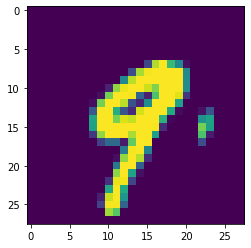

In [49]:
# plt.imshow((images[0] * 2 - 1).cpu()[0,...])
plt.imshow(images[0].cpu()[0,...] )
images[0].min()

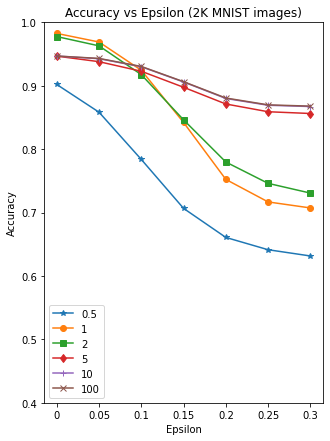

<Figure size 432x288 with 0 Axes>

In [44]:
# plot now

# over 1000 images from MNIST using evaluate_mnist.code!
which_dataset = 'mnist'
epsilons = epsilon_param[which_dataset]
symbs = ['*-', 'o-', 's-', 'd-', '+-', 'x-', '^-']

attacks = [
        'FGM',    
        'FGSM',
        'LinfPGD',
        'LinfBasicIterative',
        'LinfAdditiveUniformNoise',
        'LinfDeepFool',
        'VirtualAdversarial',
        'DDNAttack',
        'L2ProjectedGradientDescent',
        'LinfProjectedGradientDescent',
        'L2BasicIterative',
        'LinfBasicIterative',
        'L2AdditiveGaussianNoise',
        'L2AdditiveUniformNoise',
        'LinfAdditiveUniformNoise',
        'L2RepeatedAdditiveGaussianNoise',
        'L2RepeatedAdditiveUniformNoise',
        'InversionAttack',
        'BinarySearchContrastReduction',
        'LinearSearchContrastReduction',
        'GaussianBlurAttack',
        'L2DeepFoolAttack',
        'LinfDeepFoolAttack',
        'SaltAndPepperNoiseAttack',
        'LinearSearchBlendedUniformNoise',
        'Average']



fig = plt.figure(figsize=(5,7))


all_data = np.zeros((len(slopes),len(attacks)-1))
means = []



means = []
for idx, sl in enumerate(slopes):
    data = np.load(path+'/Slopes/slope-'+ which_dataset + '-' + str(sl) + '.npy',allow_pickle=True)
    data = data.tolist()
    scores = 1 - data['pred'].mean(axis=-1).mean(axis=0) # avg over images then attacks
    means.append(scores.mean())
    plt.plot(scores, symbs[idx])
    
    # accs.append(data['accs'])
    all_data[idx] = 1 - data['pred'].mean(axis=-1)[:,-1] # avg over images  corresponding to the last epsilon
    


plt.yticks(np.arange(0.4, 1.01, step=0.1))
plt.xticks(np.arange(len(epsilons)), epsilons) # np.arange(0, .35, step=0.05))
plt.title(f"Accuracy vs Epsilon (2K {which_dataset.upper()} images)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(slopes , loc='lower left')



# plt.plot(accs)

plt.show()    
plt.tight_layout()
# plt.plot(means[1:])
# plt.show()

fig.savefig(f'/gdrive/My Drive/Tmp/Slopes_{which_dataset.upper()}.png')

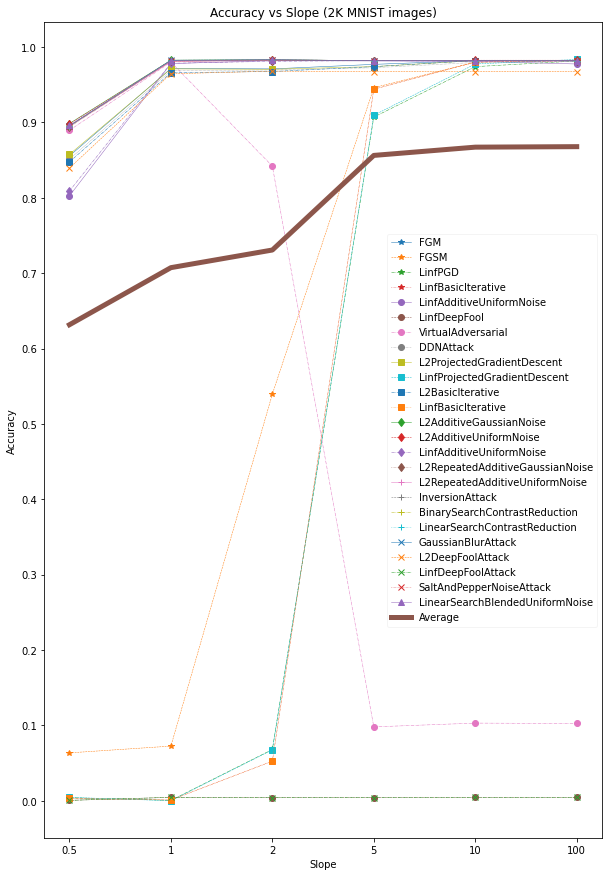

In [45]:


styles = ['-', '--', '-.', ':']
# symbs = ['*-', 'o-', 's-', 'd-', '+-', 'x-', '^-', '<-', '>-']
symbs = ['*', 'o', 's', 'd', '+', 'x', '^', '<', '>']
import itertools
stylesSymbs = list(itertools.product(symbs,styles))


fig = plt.figure(figsize=(10,15))
idx = 0
for row in all_data.T:
    plt.plot(row, ''.join(stylesSymbs[idx]), linewidth = .5)
    idx+=1
    
meanAll = all_data.mean(axis=1)    
plt.plot(meanAll, linewidth = 5)

    
plt.yticks(np.arange(0, 1.01, step=0.1))
plt.xticks(np.arange(len(slopes)), slopes) # np.arange(0, .35, step=0.05))
plt.title(f"Accuracy vs Slope (2K {which_dataset.upper()} images)")
plt.xlabel("Slope")
plt.ylabel("Accuracy")
plt.legend(attacks,framealpha=0.2, fancybox=True, loc='center right')


plt.show()

fig.savefig(f'/gdrive/My Drive/Tmp/Slopes_{which_dataset.upper()}_models.png')